In [1]:
import open3d as o3d
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [343]:
# Load the meshes
mesh_name = "000101" # must be 4 digits: xx01 indicates lower jaw, xx02 indicates upper jaw
origin_file_path = f"D:\sunny\Codes\DPS\data_teethseg\origin\{mesh_name}_origin.ply"
label_file_path = f"D:\sunny\Codes\DPS\data_teethseg\label\{mesh_name}.ply"
raw_origin_mesh = o3d.io.read_triangle_mesh(origin_file_path)
raw_label_mesh = o3d.io.read_triangle_mesh(label_file_path)

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=[0,0,0])

### 0.Recenter mesh

In [344]:
# Find two end points of the intraoral mesh by the max and min theta values
def find_key_points(mesh):
    vertices = np.asarray(mesh.vertices)
    x,y,z = vertices[:,0], vertices[:,1], vertices[:,2]
    theta = np.arctan2(z,x) + np.pi/2
    theta = np.where(theta<0, theta+2*np.pi, theta) # if theta < 0, add 2pi to make it positive
    endpt1 = vertices[np.argmin(theta)]
    endpt2 = vertices[np.argmax(theta)]
    # shift both endpts to x-z plane (i.e.y=0)
    endpt1[1] = 0
    endpt2[1] = 0
    centre = (endpt1 + endpt2) / 2
    return endpt1, endpt2, centre

# Recentre the mesh with centre keypoint at the origin, rotate the mesh about y axis such that x-axis point to endpt1
def recentre_mesh(mesh):
    endpt1, endpt2, centre_keypt = find_key_points(mesh)
    vertices = np.asarray(mesh.vertices)
    vertices = vertices - centre_keypt
    endpt1 = endpt1 - centre_keypt
    endpt2 = endpt2 - centre_keypt


    # Rotate the mesh about y axis such that x-axis point to endpt1
    theta = np.arctan2(endpt1[2], endpt1[0])
    # print(f"endpt1: {endpt1}, endpt2: {endpt2}, theta: {theta}")
    R = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    vertices = np.dot(vertices, R.T)
    endpt1 = np.dot(endpt1, R.T)
    endpt2 = np.dot(endpt2, R.T)
    print(f"endpt1: {endpt1}, endpt2: {endpt2}")
    assert endpt1[2] < 1e-6, f"end point 1 {endpt1} is not on x-axis"
    assert endpt2[2] < 1e-6, f"end point 2 {endpt2} is not on x-axis"  

    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    return mesh, endpt1, endpt2

In [345]:
# first translate mesh with its geometric center at origin
raw_origin_mesh.translate(-raw_origin_mesh.get_center())
# Then recenter the mesh with key points
origin_mesh, edp1, edp2 = recentre_mesh(raw_origin_mesh)
label_mesh, _, _ = recentre_mesh(raw_label_mesh)

# Visualize the recentred mesh with key points, with axis drawn
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector([edp1, edp2])
pc.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([origin_mesh, axes, pc])

endpt1: [27.23525814  0.          0.        ], endpt2: [-2.72352581e+01  0.00000000e+00  3.55271368e-15]
endpt1: [2.72352581e+01 0.00000000e+00 1.11022302e-16], endpt2: [-2.72352581e+01  0.00000000e+00 -3.66373598e-15]


### 2.Mesh Separation

Utils

In [ ]:
# Utils function


def set_difference(A, B):
    """ Return the elements in A but not in B"""
    A_view = A.view([('', A.dtype)] * A.shape[1])
    B_view = B.view([('', B.dtype)] * B.shape[1])
    C_view = np.setdiff1d(A_view, B_view)
    C = C_view.view(A.dtype).reshape(-1, A.shape[1])
    return C



# Preserve connected vertices which belong to a big enough / biggest cluster (remove small disconnecting clusters)
def keep_large_component(mesh, max_only=False, min_size=600):
    """ Remove small disconnected components from the mesh
    Args:
        max_only: if True, only keep the biggest component
        min_size: only works if max_only is False, 
            in which case only components with size >= min_size are kept
        
    Return:
        mesh: the mesh with small components removed
        triangles: the preserved triangles of the mesh
        removed_triangles: the removed triangles of the mesh"""
    triangles = np.asarray(mesh.triangles)
    components = np.array(mesh.cluster_connected_triangles()[0])
    comp_sizes = np.bincount(components)
    if max_only: # only keep the biggest component
        max_comp_index = np.argmax(comp_sizes)
        large_comp_mask = components == max_comp_index

    else: # keep components with size >= min_size
        large_comp_indices = np.where(comp_sizes >= min_size)[0]
        large_comp_mask = np.isin(components, large_comp_indices)

    preserved_triangles = triangles[large_comp_mask]
    removed_triangles = triangles[np.logical_not(large_comp_mask)]
    mesh.triangles = o3d.utility.Vector3iVector(preserved_triangles) # keep the biggest component

    return mesh, triangles, removed_triangles

Upper Surface

In [349]:
# Identify upward facing vertices (upper vertices) and visualize by coloring 

def extract_up_triangles(mesh, xpos_min=10, xpos_max=-10, ypos_min=-2, ynorm_min=0.6):
    """ All vertices are preserved. 
        Triangles with all 3 vertices upward facing are preserved"""

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)
    
    assert xpos_min > xpos_max, "xpos_min must be greater than xpos_max: to avoid middle region"
    up_vert_xpos_mask = np.logical_or((vertices[:,0]) > xpos_min, (vertices[:,0]) < xpos_max)
    up_vert_ypos_mask = (vertices[:,1]) > ypos_min
    up_vert_norm_mask = normals[:,1] > ynorm_min
    up_vert_mask = up_vert_xpos_mask & up_vert_ypos_mask & up_vert_norm_mask 
    # print(np.sum(up_vert_mask))
    
    up_mesh = copy.deepcopy(mesh)
    up_triangles_mask = np.all(up_vert_mask[triangles], axis=1) # all 3 vertices of the triangle are upward facing
    up_triangles = triangles[up_triangles_mask]
    up_mesh.triangles = o3d.utility.Vector3iVector(up_triangles)

    up_mesh, up_triangles, _ = keep_large_component(up_mesh, min_size=600)
    unsampled_triangles = set_difference(triangles, up_triangles)
    unsampled_mesh = copy.deepcopy(mesh)
    unsampled_mesh.triangles = o3d.utility.Vector3iVector(unsampled_triangles)
    unsampled_mesh, unsampled_trinagles, _ = keep_large_component(unsampled_mesh, max_only=True)
    
    # Triangles are either in up_triangles or unsampled_triangles
    up_triangles = set_difference(triangles, unsampled_triangles)
    # up_mesh.triangles = o3d.utility.Vector3iVector(up_triangles)

    return up_triangles, unsampled_mesh

# Execution
up_triangles, unsampled_mesh = extract_up_triangles(label_mesh)

# Visualize the upward facing triangles
# TODO: !!!!

-0.9387471695068522 0.9999540447773944
7638
Number of triangles before: 13301
Number of triangles after: 11505
Number of triangles in upward mesh: 13095
Number of triangles in unsampled mesh: 26890
Number of triangles in origin mesh: 39985


Inner and Outer Surface


In [350]:
# Separate the original mesh vertices into inward-facing and outward-facing vertices relative to the origin
# With original (non re-centered mesh)


def separate_io_triangles(mesh):
    """ Separate the original mesh triangles into 
    inward-facing and outward-facing triangles relative to the origin
    
    All vertices are preserved."""

    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    viewpt1 = np.mean(vertices, axis=0)
    vertices_vp1 = vertices - viewpt1
    viewpt2 = viewpt1 / 2
    vertices_vp2 = vertices - viewpt2

    normals = np.asarray(mesh.vertex_normals)

    # analyse the mesh in 3 parts (based on z coords)
    # each part has different viewpt for normal thresholding
    pos_mask1 = vertices[:, 2] > viewpt1[2]
    in_vert_mask1 = np.logical_and(np.sum(normals * vertices_vp1, axis=1) < 0, pos_mask1)
    pos_mask2 = np.logical_and(viewpt2[2] < vertices[:, 2], vertices[:, 2] < viewpt1[2])
    in_vert_mask2 = np.logical_and(np.sum(normals * vertices_vp2, axis=1) < 0, pos_mask2)
    pos_mask3 = vertices[:, 2] < viewpt2[2]
    in_vert_mask3 = np.logical_and(np.sum(normals * vertices, axis=1) < 0, pos_mask3)

    # merge the 3 masks
    in_vert_mask = in_vert_mask1 + in_vert_mask2 + in_vert_mask3

    # separate triangles
    in_triangles_mask = np.all(in_vert_mask[triangles], axis=1)
    in_triangles = triangles[in_triangles_mask]
    in_mesh = copy.deepcopy(mesh)
    in_mesh.triangles = o3d.utility.Vector3iVector(in_triangles)

    out_triangles_mask = np.logical_not(in_triangles_mask)
    out_triangles = triangles[out_triangles_mask]
    out_mesh = copy.deepcopy(mesh)
    out_mesh.triangles = o3d.utility.Vector3iVector(out_triangles)


    # clean up
    in_mesh, in_triangles, in_to_out_triangles = keep_large_component(in_mesh, min_size=200)
    out_mesh, out_triangles, out_to_in_triangles = keep_large_component(out_mesh, min_size=200)

    # add out_to_in_triangles to in_triangles
    in_triangles = np.concatenate([in_triangles, out_to_in_triangles])
    out_triangles = set_difference(triangles, in_triangles)

    return in_triangles, out_triangles


in_triangles, out_triangles = separate_io_triangles(unsampled_mesh)

# check all triangles are accounted for
assert len(in_triangles) + len(out_triangles) == len(unsampled_mesh.triangles), "Sum of inward and outward triangles not equal to unsampled triangles"
assert len(up_triangles) + len(in_triangles) + len(out_triangles) == len(origin_mesh.triangles), "Sum of upward, inward and outward triangles not equal to total triangles"



Number of triangles before: 12815
Number of triangles after: 12573
Number of triangles before: 14075
Number of triangles after: 13733
Number of triangles in inward mesh: 12915
Number of triangles in outward mesh: 13975
Number of triangles in unsampled mesh: 26890


### 3. Project Original 3D Mesh

UV mapping projection and normalization

In [351]:

def UVmap_planar(vertices, if_norm=True):
    """ UV mapping from xyz coordinates of upward-facing vertices
    Args:
        vertices: xyz coordinates of vertices

    Return:
        uv_coords: uv coordinates of vertices (u=x, v=z) 
        depth_map: projection depth = y_max - y"""

    uv_coords = vertices[:, [0, 2]]
    # depth_map: projection depth = max(y) - y
    depth_map = np.max(vertices[:, 1]) - vertices[:, 1]

    return uv_coords, depth_map


def UVmap_cylindrical(vertices, if_inward=True):
    """ UV mapping from xyz coordinates of inward or outward facing vertices
    Args:
        vertices: xyz coordinates of vertices
        if_inward: if True, the vertices are inward facing, projection depth = xz_norm
                   if False, the vertices are outward facing = max(xz_norm) - xz_norm
        
    Return:
        uv_coords: uv coordinates of vertices (u=theta, v=y) 
        depth_map: projection depth"""

    uv_coords = []
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        y = y
        uv_coords.append([theta, y])

    depth_map = np.linalg.norm(vertices[:, [0, 2]], axis=1)
    if not if_inward:
        depth_map = np.max(depth_map) - depth_map
    
    return np.array(uv_coords), depth_map



def normalize_uv_coords(uv_coords, u_range, v_range, with_nl=False):
    uv_norm_coords = np.copy(uv_coords)
    u_min, u_max = u_range
    v_min, v_max = v_range
    uv_norm_coords[:, 0] = (uv_coords[:, 0] - u_min) / (u_max - u_min)
    uv_norm_coords[:, 1] = (uv_coords[:, 1] - v_min) / (v_max - v_min)

    # non-linear transformation to reduce distortion in theta
    # set to True if the mesh is cylindrically projected
    if with_nl: 
        uv_norm_coords[:,0] = np.sin((uv_coords[:,0] -0.5) * np.pi) / 2 + 0.5

    return uv_norm_coords



In [ ]:
# Execution

# Get the vertices of the origin mesh
vertices = np.asarray(origin_mesh.vertices)
# UV mapping for all vertices in 3 cases NOTE: all vertices are projected in each case!!!!!!
uv_out, vert_depth_out = UVmap_cylindrical(vertices, if_inward=False)
uv_in, vert_depth_in = UVmap_cylindrical(vertices, if_inward=True)
uv_up, vert_depth_up = UVmap_planar(vertices)

# Normalize the uv coordinates
uv_norm_out = normalize_uv_coords(uv_out, (0, 2*np.pi), (-9, 7), with_nl=True)
uv_norm_in = normalize_uv_coords(uv_in, (0, 2*np.pi), (-8, 8), with_nl=True)
uv_norm_up = normalize_uv_coords(uv_up, (-40, 40), (0, 50))

In [ ]:
# Keep track of vertices which belong to each case out of all vertices
out_vertices = np.asarray(origin_mesh.vertices)[out_triangles]
out_vert_idx = np.where(np.isin(vertices, out_vertices).all(axis=1))[0]

in_vertices = np.asarray(origin_mesh.vertices)[in_triangles]
in_vert_idx = np.where(np.isin(vertices, in_vertices).all(axis=1))[0]

up_vertices = np.asarray(origin_mesh.vertices)[up_triangles]
up_vert_idx = np.where(np.isin(vertices, up_vertices).all(axis=1))[0]

In [ ]:
# COLORS!!!!
vertices_originRGB_raw = np.asarray(origin_mesh.vertex_colors) # r,g,b within (0-1)
vertices_labelRGB_raw = np.asarray(label_mesh.vertex_colors) # black/grey/non-white >= (0,0,0) for plaque, white=(1,1,1) for non-plaque

# Convert RGB format into 0-255
# Flip plaque representation from dark (black or grey) to white
vertices_originRGB = (vertices_originRGB_raw * 255).astype(np.uint8) # 0-255
vertices_labelRGB = ((1-vertices_labelRGB_raw) * 255).astype(np.uint8) # 0-255, non-black>(0,0,0) for plaue, black=(0,0,0) for non-plaque

Rasterization

In [ ]:
def rasterize(uv_norm_coords, vert_depth, xx_triangles, vert_originRGB, vert_labelRGB, pxl=256, is_ou=True):
    if is_ou:
        px_h = pxl
        px_w = pxl*8 # 2048
    else:
        px_h = px_w = pxl
    
    # Initialize uv_pixel of same shape as uv_norm_coords
    uv_pixel = np.copy(uv_norm_coords)
    uv_pixel[:, 0] = (uv_norm_coords[:, 0] * px_w-1).astype(np.int32)
    uv_pixel[:, 1] = (uv_norm_coords[:, 1] * px_h-1).astype(np.int32)

    # Calculate projection depth for each triangle face (mean projection depth of 3 vertices)
    tri_depth = np.mean(vert_depth[xx_triangles], axis=1)

    # Sort the triangles by depth (ascending)
    sorted_tri_idx = np.argsort(tri_depth)
    sorted_tri= xx_triangles[sorted_tri_idx]


    """get original colors and labels for each triangle face"""
    tri_originRGB = get_tri_RGB(sorted_tri, vert_originRGB)
    tri_labelRGB = get_tri_RGB(sorted_tri, vert_labelRGB)


def get_tri_RGB(triangles, vertex_RGB):
    tri_RGBs = []
    for triangle in triangles:
        colors_3vert = vertex_RGB[triangle]
        # Get the minimum color value for each channel
        tri_rgb = np.min(colors_3vert, axis=0) # TODO: min vs mean!!!!
        tri_RGBs.append(tri_rgb)
    return np.array(tri_RGBs)

In [352]:
mesh_out = outward_mesh
mesh_in = inward_mesh
label_mesh_out = copy.deepcopy(label_mesh)
label_mesh_out.triangles = o3d.utility.Vector3iVector(outward_triangles)
label_mesh_in = copy.deepcopy(label_mesh)
label_mesh_in.triangles = o3d.utility.Vector3iVector(inward_triangles)


# Extract the vertices, triangles, vertex colors and face colors
vertices_out = np.asarray(mesh_out.vertices)
triangles_out = np.asarray(mesh_out.triangles)
vertex_colors_out = np.asarray(mesh_out.vertex_colors)
face_colors_out = get_face_colors(triangles_out, vertex_colors_out)
vertex_labels_out = np.asarray(label_mesh_out.vertex_colors)
face_labels_out = get_face_colors(triangles_out, vertex_labels_out)

vertices_in = np.asarray(mesh_in.vertices)
triangles_in = np.asarray(mesh_in.triangles)
vertex_colors_in = np.asarray(mesh_in.vertex_colors)
face_colors_in = get_face_colors(triangles_in, vertex_colors_in)
vertex_labels_in = np.asarray(label_mesh_in.vertex_colors)
face_labels_in = get_face_colors(triangles_in, vertex_labels_in)

# Flip face_labels colors (white (1,1,1) to black (0,0,0), black to white)
face_labels_out = 1 - face_labels_out
face_labels_in = 1 - face_labels_in

# Projection
uv_out, vert_depth_out = xyz_to_uv(vertices_out)
uv_in, vert_depth_in = xyz_to_uv(vertices_in)

# Normalize the uv coordinates into [0, 1]
uv_norm_out = normalize_uv_coordinates(uv_out, is_outward=True)
uv_norm_in = normalize_uv_coordinates(uv_in, is_outward=False)


In [353]:
def nonlinear_uv(uv_coordinates):
    x_coords = uv_coordinates[:, 0]
    y_coords = uv_coordinates[:, 1]
    x_coords_transformed = np.sin((x_coords - 0.5) * np.pi) / 2 + 0.5
    uv_coordinates_transformed = np.stack((x_coords_transformed, y_coords), axis=1)
    return uv_coordinates_transformed

uv_norm_out_nl = nonlinear_uv(uv_norm_out)
uv_norm_in_nl = nonlinear_uv(uv_norm_in)

In [354]:
# print((np.where(uv_out[:,0]>0)[0]).shape)
# print((np.where(uv_out[:,0]<0)[0]).shape)
# print((np.where(uv_in[:,0]>0)[0]).shape)
# print((np.where(uv_in[:,0]<0)[0]).shape)

In [355]:
px_h = 256 # y axis resolution
px_w = px_h * 8 # theta axis resolution
# Convert uv cooridnates to pixel coordinates, scaling theta to [0,2048) range
uv_pixel_out = np.copy(uv_norm_out_nl)
uv_pixel_out[:, 0] = (uv_pixel_out[:, 0] * px_w-1).astype(np.int32)
uv_pixel_out[:, 1] = (uv_pixel_out[:, 1] * px_h-1).astype(np.int32)

uv_pixel_in = np.copy(uv_norm_in_nl)
uv_pixel_in[:, 0] = (uv_pixel_in[:, 0] * px_w-1).astype(np.int32)
uv_pixel_in[:, 1] = (uv_pixel_in[:, 1] * px_h-1).astype(np.int32)

# FIXME: need to save the uv_pixel_out and uv_pixel_in for each mesh!!!!!!!!!

# Calculate mean projection depth for each face
face_depth_out = np.mean(vert_depth_out[triangles_out], axis=1)
face_depth_in = np.mean(vert_depth_in[triangles_in], axis=1)

# Sort the faces by depth (ascending)
sorted_indices_out = np.argsort(face_depth_out)
sorted_triangles_out = triangles_out[sorted_indices_out]
sorted_face_colors_out = face_colors_out[sorted_indices_out]
sorted_face_colors_out = (sorted_face_colors_out * 255).astype(np.uint8)
sorted_face_labels_out = face_labels_out[sorted_indices_out]
sorted_face_labels_out = (sorted_face_labels_out * 255).astype(np.uint8)


sorted_indices_in = np.argsort(face_depth_in)
sorted_triangles_in = triangles_in[sorted_indices_in]
sorted_face_colors_in = face_colors_in[sorted_indices_in]
sorted_face_colors_in = (sorted_face_colors_in * 255).astype(np.uint8)
sorted_face_labels_in = face_labels_in[sorted_indices_in]
sorted_face_labels_in = (sorted_face_labels_in * 255).astype(np.uint8)

# Initialize the large 2D image (1024x8192) for the entire dataset
entire_origin_image_out = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_origin_image_in = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_label_image_out = np.zeros((px_h, px_w, 3), dtype=np.uint8)
entire_label_image_in = np.zeros((px_h, px_w, 3), dtype=np.uint8)



# Rasterize the triangles onto the large image
# Crop the large image into 8 sections, each with size 256x256x3
def rasterize(sorted_triangles, sorted_face_colors, uv_pixel, large_image, n_sec = None):
    """ Return section_images as numpy arrays, with shape (8, 1024, 1024, 3)"""
    for i, triangle in enumerate(sorted_triangles):
        pts = uv_pixel[triangle].reshape((-1, 1, 2)).astype(np.int32)
        face_color = tuple(int(c) for c in sorted_face_colors[i])  # Convert to tuple for cv2.fillPoly
        cv2.fillPoly(large_image, [pts], face_color)

    if n_sec is None:
        return large_image
    else:
        section_images = np.array([large_image[:, i*px_h:(i+1)*px_h] for i in range(n_sec)])
        return section_images, large_image

origin_images_out, entire_origin_image_out = rasterize(sorted_triangles_out, sorted_face_colors_out, uv_pixel_out, entire_origin_image_out, n_sec = 8)
origin_images_in, entire_origin_image_in = rasterize(sorted_triangles_in, sorted_face_colors_in, uv_pixel_in, entire_origin_image_in, n_sec = 8)
origin_images = np.array([origin_images_out, origin_images_in])
# flatten into (16, 256, 256, 3)
origin_images = origin_images.reshape(-1, px_h, px_h, 3)

label_images_out, entire_label_image_out = rasterize(sorted_triangles_out, sorted_face_labels_out, uv_pixel_out, entire_label_image_out, n_sec = 8)
label_images_in, entire_label_image_in = rasterize(sorted_triangles_in, sorted_face_labels_in, uv_pixel_in, entire_label_image_in, n_sec = 8)
label_images = np.array([label_images_out, label_images_in])
# flatten into (16, 256, 256, 3)
label_images = label_images.reshape(-1, px_h, px_h, 3)

save_dir = "D:\sunny\Codes\DPS\data_npy2d"

In [356]:
print(origin_images.shape)
print(label_images.shape) # color values are 0 to 255

(16, 256, 256, 3)
(16, 256, 256, 3)


In [357]:
# Convert label_images into binary masks (0 or 1)
# set pixels with any non-zero rgb values to 1
# else if pixel has color (0,0,0) set to 0
def convert_to_binary(label_images):
    binary_images = np.any(label_images != 0, axis=-1).astype(np.uint8)
    return binary_images

label_images_binary = convert_to_binary(label_images)
print(label_images_binary.shape)


(16, 256, 256)


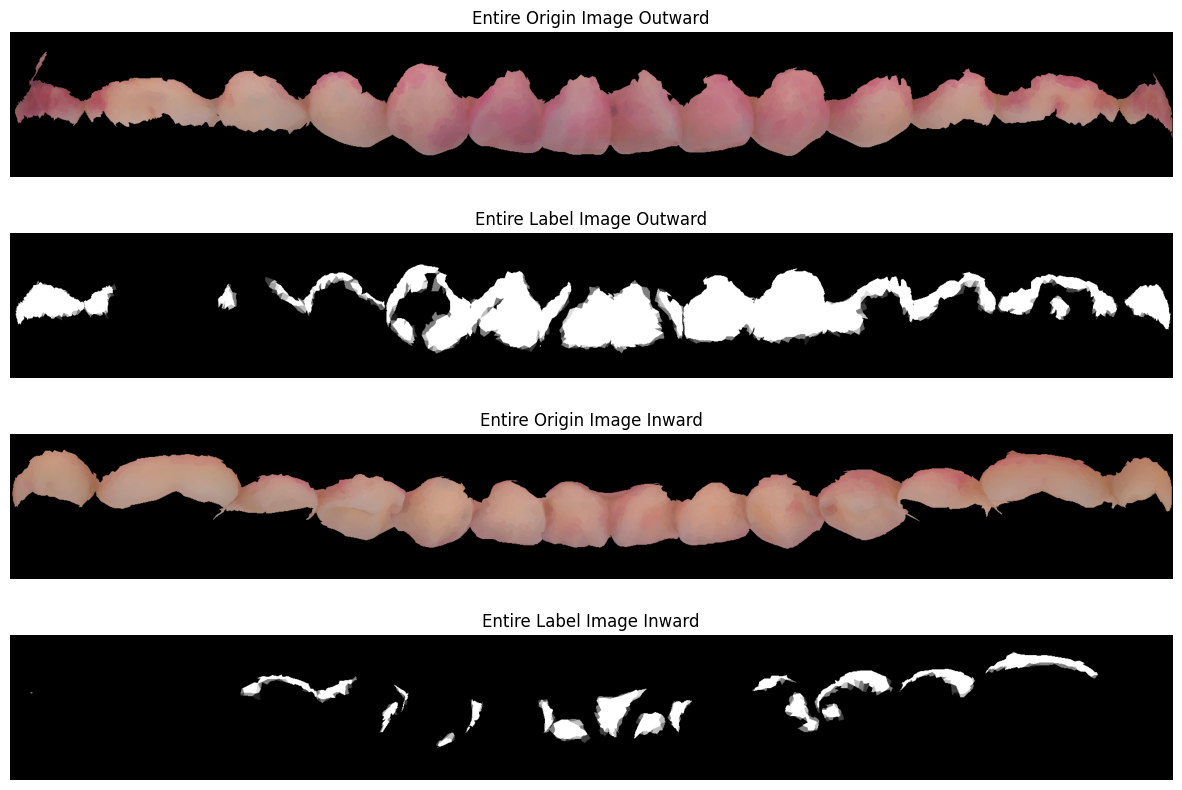

In [358]:
# Display the large image for visualization
fig, ax = plt.subplots(4,1, figsize=(15, 10))

ax[0].imshow(entire_origin_image_out)
ax[0].set_title("Entire Origin Image Outward")
ax[0].axis('off')


ax[1].imshow(entire_label_image_out)
ax[1].set_title("Entire Label Image Outward")
ax[1].axis('off')

ax[2].imshow(entire_origin_image_in)
ax[2].set_title("Entire Origin Image Inward")
ax[2].axis('off')

ax[3].imshow(entire_label_image_in)
ax[3].set_title("Entire Label Image Inward")
ax[3].axis('off')

# plt.savefig(os.path.join(save_dir, "jpg", f"{mesh_name}.jpg"))

plt.show()

In [359]:

# save_origin_path = os.path.join(save_dir, "origin", f'{mesh_name}.npy')
# save_label_path = os.path.join(save_dir, "label", f'{mesh_name}.npy')

# # Save the section images as a single npy file
# np.save(save_origin_path, origin_images)
# np.save(save_label_path, label_images_binary)


In [360]:
# tensor_origin = np.load(save_origin_path)
# tensor_label = np.load(save_label_path)
# origin_image_test = tensor_origin[4, :, :, :]
# label_image_test = tensor_label[4, :, :]

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# ax[0].imshow(origin_image_test)
# ax[0].axis("off")
# ax[1].imshow(label_image_test)
# ax[1].axis("off")
# plt.show()

In [361]:
# # convert rgb to bgr
# origin_image_test = cv2.cvtColor(origin_image_test, cv2.COLOR_RGB2BGR)
# label_image_test = cv2.cvtColor(label_image_test, cv2.COLOR_RGB2BGR)

# # save origin_image_test and label_image_test as jpg
# cv2.imwrite(os.path.join(save_dir, "jpg", f"{mesh_name}_origin_image_test.jpg"), origin_image_test)
# cv2.imwrite(os.path.join(save_dir, "jpg", f"{mesh_name}_label_image_test.jpg"), label_image_test)



Planar Projection of upper surface

In [365]:
mesh_up = upward_mesh
triangles_up = np.asarray(mesh_up.triangles)
label_mesh_up = copy.deepcopy(label_mesh)
label_mesh_up.triangles = o3d.utility.Vector3iVector(triangles_up)


# Extract the vertices, triangles, vertex colors and face colors
vertices_up = np.asarray(mesh_up.vertices)

vertex_colors_up = np.asarray(mesh_up.vertex_colors)
face_colors_up = get_face_colors(triangles_up, vertex_colors_up)
vertex_labels_up = np.asarray(label_mesh_up.vertex_colors)
face_labels_up = get_face_colors(triangles_up, vertex_labels_up)

# Flip face_labels colors (white (1,1,1) to black (0,0,0), black to white)
face_colors_up = (face_colors_up * 255).astype(np.uint8)
face_labels_up = ((1 - face_labels_up) * 255).astype(np.uint8)


# Projection
uv_up, vert_depth_up = vertices_up[:, [0, 2]], vertices_up[:, 1]





def normalize_uv_coord_up(uv_coords,
                          x_range=(-40, 40),
                          z_range=(0, 50)):
    uv_coords_norm = np.copy(uv_coords)
    x_min, x_max = x_range
    z_min, z_max = z_range
    uv_coords_norm[:, 0] = (uv_coords[:, 0] - x_min) / (x_max - x_min)
    uv_coords_norm[:, 1] = (uv_coords[:, 1] - z_min) / (z_max - z_min)
    return uv_coords_norm



# Normalize the uv coordinates into [0, 1]
uv_norm_up = normalize_uv_coord_up(uv_up)

In [366]:
print(np.min(uv_up[:,0]), np.max(uv_up[:,0]))
print(np.min(uv_up[:,1]), np.max(uv_up[:,1]))

-37.32782533832454 36.49390478570516
-1.5136777878280452 48.16409174240824


In [367]:
# count number of vertice colors != (0,0,0)
print(np.sum(face_labels_up != 0., axis=0))
print(face_labels_up[-1])

print(len(face_labels_up))
print(len(triangles_up))

[760 760 760]
[0 0 0]
13095
13095


In [368]:
px = 1024
# Convert uv cooridnates to pixel coordinates, scaling x,z to [0,1024) range
uv_pixel_up = np.copy(uv_norm_up)
uv_pixel_up[:, 0] = (uv_pixel_up[:, 0] * px-1).astype(np.int32)
uv_pixel_up[:, 1] = (uv_pixel_up[:, 1] * px-1).astype(np.int32)



# Initialize the large 2D image (1024x1024x3) for the entire dataset
origin_image_up = np.zeros((px, px, 3), dtype=np.uint8)
label_image_up = np.zeros((px, px, 3), dtype=np.uint8)


# Rasterize the triangles onto the large image
# Crop the large image into 8 sections, each with size 256x256x3
def rasterize(triangles, face_colors, uv_pixel, large_image):
    """ Return section_images as numpy arrays, with shape (1024, 1024, 3)"""
    print(np.sum(face_colors != 0., axis=0))
    print(len(face_colors))
    for i, triangle in enumerate(triangles):
        pts = uv_pixel[triangle].reshape((-1, 1, 2)).astype(np.int32)
        
        face_color = tuple(int(c) for c in face_colors[i])  # Convert to tuple for cv2.fillPoly
        cv2.fillPoly(large_image, [pts], face_color)
    return large_image



# Rasterize the triangles onto the large image
origin_image_up = rasterize(triangles_up, face_colors_up, uv_pixel_up, origin_image_up)
label_image_up = rasterize(triangles_up, face_labels_up, uv_pixel_up, label_image_up)
# label_images_binary_up = convert_to_binary(label_image_up)

print(np.max(face_labels_up))
print(np.max(label_image_up))

[13095 13095 13095]
13095
[760 760 760]
13095
255
255


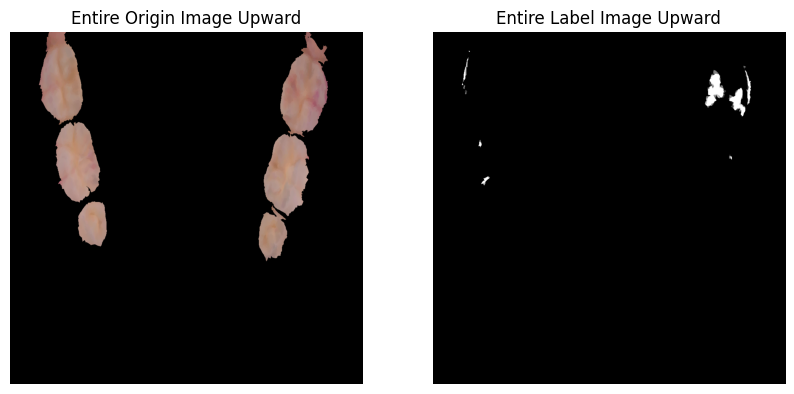

In [369]:
# Display the large image for visualization
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(origin_image_up)
ax[0].set_title("Entire Origin Image Upward")
ax[0].axis('off')

ax[1].imshow(label_image_up)
ax[1].set_title("Entire Label Image Upward")
ax[1].axis('off')

# plt.savefig(os.path.join(save_dir, "jpg", f"{mesh_name}_upward.jpg"))

plt.show()

### Map back to 3D

In [370]:

# FIXME:!!!!!!
# In contrast, GT: vertex_labels_out, vertex_labels_in are not flipped, RGB (0-1)

# Assuming the predicted label images has been converted from binary masks to RGB images (0-255)
# intensity flipped (1 to 0, 0 to 1)
# white-grey: non-zero (>0) class 1; black: (0,0,0) class 0
predicted_label_images = label_images  # Directly load the GT label images as the predicted label images (ideal case test)

# Reshape the predicted label images into the original 8x1024x1024 format from the 16x256x256 format
print(predicted_label_images.shape)
predicted_label_images = predicted_label_images.reshape(2, 8, px_h, px_h, 3)
# Divide by 255 to convert back to [0, 1] range and flip the intensity (1 to 0, 0 to 1)
# black-grey: non-1s (<1) class1; white: (1,1,1) class 0 (same format as mesh GT labels)
predicted_label_images = 1 - predicted_label_images / 255


def determine_pred_labels_for_uv(uv_pixel_in, uv_pixel_out, predicted_label_images):
    """ Assign labels to points based on predicted label images """
    # Initialize arrays to store the labels of each point or triangle
    vertex_pred_labels_out = np.zeros((uv_pixel_out.shape[0], 3), dtype=np.int8)
    vertex_pred_labels_in = np.zeros((uv_pixel_in.shape[0], 3), dtype=np.int8)
    
    for i, (u, v) in enumerate(uv_pixel_out):
        section = int(u // px_h) # Determine the section of the point
        local_u = int(u % px_h) # Determine the local u coordinate within the section
        v = np.clip(int(v), 0, 255) # Ensure the v coordinate is within the pixel y range
        vertex_pred_labels_out[i] = predicted_label_images[0, section, v, local_u] # 0 for outward-facing

    for i, (u, v) in enumerate(uv_pixel_in):
        section = int(u // px_h) # Determine the section of the point
        local_u = int(u % px_h) # Determine the local u coordinate within the section
        v = np.clip(int(v), 0, 255) # Ensure the v coordinate is within the pixel y range
        vertex_pred_labels_in[i] = predicted_label_images[1, section, v, local_u] # 1 for inward-facing
    return vertex_pred_labels_out, vertex_pred_labels_in


# Determine the labels for the points in 'out' and 'in' UV coordinates
vertex_pred_labels_out, vertex_pred_labels_in = determine_pred_labels_for_uv(uv_pixel_in, uv_pixel_out, predicted_label_images)

# # For each triangle, determine the label by majority voting (or another method) based on its vertices' labels
# face_pred_labels_out = np.array([np.argmax(np.bincount(vertex_pred_labels_out[triangle])) for triangle in sorted_triangles_out])
# face_pred_labels_in = np.array([np.argmax(np.bincount(vertex_pred_labels_in[triangle])) for triangle in sorted_triangles_in])

# Now, triangle_labels_out and triangle_labels_in contain the labels for each triangle based on the predicted label images
# FIXME: Compare the predicted labels with the ground truth labels to evaluate the model
# FIXME: point_labels vs vertex_labels (GT); triangle_labels vs face_labels (GT) --> compute IoU, Dice, etc. metrics
print(np.unique(vertex_labels_out))
print(vertex_labels_out[0])
print(np.unique(vertex_pred_labels_out))
print(vertex_pred_labels_out[0])

# Compute the IoU and Dice scores for the vertices
def compute_metrics(gt_labels, pred_labels, binary=True):
    """ Compute the IoU and Dice scores for the outward-facing faces """
    if binary:
        gt_labels = gt_labels != np.array([0.,0.,0.]) # returns True if label <1 (class1), False if label is 1 (white class0)
        pred_labels = pred_labels != np.array([0,0,0])
    intersection = np.sum(np.logical_and(gt_labels, pred_labels))
    union = np.sum(np.logical_or(gt_labels, pred_labels))
    iou = intersection / union
    dice = 2 * intersection / (np.sum(gt_labels) + np.sum(pred_labels))
    return iou, dice

iou_out, dice_out = compute_metrics(vertex_labels_out, vertex_pred_labels_out)
iou_in, dice_in = compute_metrics(vertex_labels_in, vertex_pred_labels_in)

print(f"IoU (outward): {iou_out:.4f}, Dice (outward): {dice_out:.4f}")
print(f"IoU (inward): {iou_in:.4f}, Dice (inward): {dice_in:.4f}")

(16, 256, 256, 3)
[0.         0.0627451  0.1254902  0.18823529 0.25098039 0.37647059
 0.43921569 0.50196078 0.56078431 0.62352941 0.68627451 0.71764706
 0.74901961 0.81176471 0.8745098  0.9372549  1.        ]
[1. 1. 1.]
[0 1]
[1 1 1]
IoU (outward): 0.6446, Dice (outward): 0.7839
IoU (inward): 0.8184, Dice (inward): 0.9001


In [371]:
# visualize the predicted label images in mesh form
def visualize_pred_labels(GTlabel_mesh, vertex_pred_labels): # assume vertex_pred_labels is in RGB format (0-1) non-binary
    """ Visualize the predicted labels on the mesh """
    mesh_pred = copy.deepcopy(GTlabel_mesh)
    vertices = np.asarray(mesh_pred.vertices)
    triangles = np.asarray(mesh_pred.triangles)
    colors = np.asarray(mesh_pred.vertex_colors).astype(np.int8)



    for i in range(len(vertices)):
       if not np.array_equal(vertex_pred_labels[i], np.array([1, 1, 1])):  # Check if predicted label is not white
            if np.array_equal(colors[i], np.array([1, 1, 1])):  # False positive
                colors[i] = np.array([1, 0, 0]) # Red
            else: # True positive
                colors[i] = np.array([0, 1, 0]) # Green
        
    mesh_pred.vertex_colors = o3d.utility.Vector3dVector(colors)

    return mesh_pred

In [372]:
mesh_pred_out = visualize_pred_labels(label_mesh_out, vertex_pred_labels_out)
mesh_pred_in = visualize_pred_labels(label_mesh_in, vertex_pred_labels_in)

# set scene background to grey
# o3d.visualization.draw_geometries([mesh_pred_out, mesh_pred_in, coordinate_frame, grid])

# Visualize the meshes with a grey background
def custom_draw_geometry_with_background(geometry_list, window_name="Open3D"):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=window_name)
    for geometry in geometry_list:
        vis.add_geometry(geometry)
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0.5, 0.5, 0.5])
    vis.run()
    vis.destroy_window()

custom_draw_geometry_with_background([mesh_pred_out, mesh_pred_in], window_name="Predicted Labels")
